In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import emg3d

import sampledata

name = "Block-1src-130rec-1freq"

In [2]:
%matplotlib widget

In [3]:
rec_x = np.arange(26)*100+500
rec_y = np.array([-1000, -500, 0, 500, 1000])
rec_z = 0.0
rec = emg3d.surveys.txrx_coordinates_to_dict(
        emg3d.RxElectricPoint,
        (np.tile(rec_x, rec_y.size), rec_y.repeat(rec_x.size), rec_z, 0, 0)
)

src = emg3d.TxElectricDipole((0, 0, 0, 0, 0))
frequencies = np.array([1.0, ])
survey = emg3d.surveys.Survey(
    sources=src,
    receivers=rec,
    frequencies=frequencies,
    noise_floor=1e-17,
    relative_error=0.05,
)
survey

:: Survey ::

<xarray.Dataset> Size: 6kB
Dimensions:   (src: 1, rec: 130, freq: 1)
Coordinates:
  * src       (src) <U6 24B 'TxED-1'
  * rec       (rec) <U8 4kB 'RxEP-001' 'RxEP-002' ... 'RxEP-129' 'RxEP-130'
  * freq      (freq) <U3 12B 'f-1'
Data variables:
    observed  (src, rec, freq) complex128 2kB (nan+nanj) ... (nan+nanj)
Attributes:
    noise_floor:     1e-17
    relative_error:  0.05

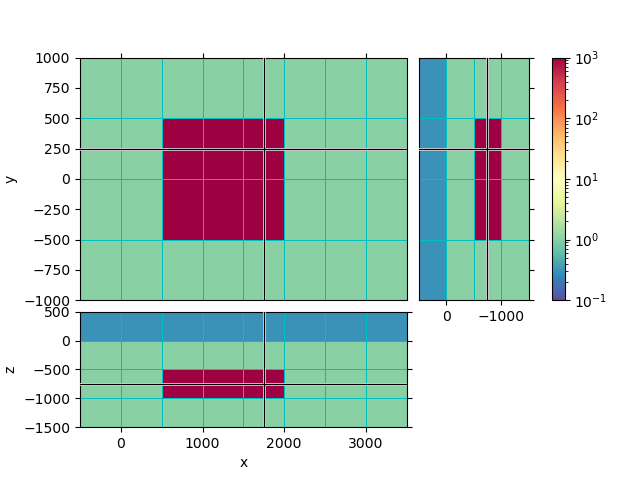

In [4]:
hx = np.ones(8)*500.0
hyz = np.ones(4)*500.0
grid = emg3d.TensorMesh([hx, hyz, hyz], [-500, -1000, -1500])

model = emg3d.Model(grid, 1.0, mapping='Conductivity')
model_init = model.copy()

# Target
model.property_x[2:5, 1:-1, 1:-2] = 0.001
# Water
model_init.property_x[:, :, -1] = 3.3
model.property_x[:, :, -1] = 3.3


grid.plot_3d_slicer(
    1/model.property_x, zslice=-750,
    pcolor_opts={'cmap': 'Spectral_r', 'norm': LogNorm(vmin=.1, vmax=1000), 'lw': 0.5, 'color': 'c'}
)

# Plot survey in figure above
fig = plt.gcf()
fig.suptitle('Resistivity model (Ohm.m) and survey layout')
axs = fig.get_children()
rec_coords = survey.receiver_coordinates()
src_coords = survey.source_coordinates()
axs[1].plot(rec_coords[0], rec_coords[1], 'bv')
axs[2].plot(rec_coords[0], rec_coords[2], 'bv')
axs[3].plot(rec_coords[2], rec_coords[1], 'bv')
axs[1].plot(src_coords[0], src_coords[1], 'r*')
axs[2].plot(src_coords[0], src_coords[2], 'r*')
axs[3].plot(src_coords[2], src_coords[1], 'r*')

In [5]:
# Create an emg3d Simulation instance
sim = emg3d.simulations.Simulation(
    name=name,
    survey=survey.copy(),
    model=model,
    gridding='both',
    max_workers=10,
    gridding_opts={'center_on_edge': False},
    receiver_interpolation='linear',
    solver_opts={'tol_gradient': 1e-3},
    tqdm_opts=False,
)
sim

:: Simulation «Block-1src-130rec-1freq» ::

- Survey: 1 sources; 130 receivers; 1 frequencies
- Model: conductivity; isotropic; 8 x 4 x 4 (128)
- Gridding: Frequency- and source-dependent grids; 64 x 48 x 40 (122,880)

Data saved to «/home/dtr/Codes/devInv/data/Block-1src-130rec-1freq.h5»
[emg3d v1.8.4.dev11+g36578d6 (format 1.0) on 2024-09-02T14:06:41.321005].
Data loaded from «/home/dtr/Codes/devInv/data/Block-1src-130rec-1freq.h5»
[emg3d v1.8.4.dev11+g36578d6 (format 1.0) on 2024-09-02T14:06:41.321005].


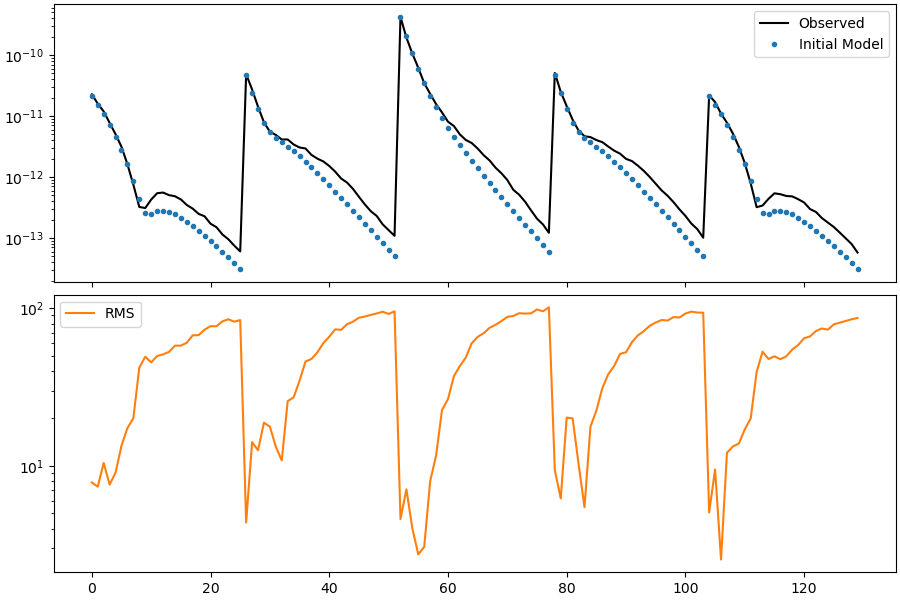

In [6]:
sampledata.create_data(name, sim, model_init)
sampledata.plot_obs_initial(name)

In [7]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Mon Sep 02 14:06:41 2024 CEST

                OS : Linux (Ubuntu 22.04)
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC
  12.3.0]

             numpy : 1.26.4
             scipy : 1.14.0
             numba : 0.60.0
             emg3d : 1.8.4.dev11+g36578d6
           empymod : 2.3.2.dev7+g2133d34.d20240729
            xarray : 2024.6.0
        discretize : 0.10.1.dev15+gf89e5ff7.d20240902
              h5py : 3.11.0
        matplotlib : 3.9.0
              tqdm : 4.66.4
           IPython : 8.26.0
--------------------------------------------------------------------------------